### QUANTITATIVE ANALYSIS - TECHNICAL INDICATORS
===================================================

This notebook performs quantitative analysis on stock price data using technical indicators:

1. DATA PREPARATION
   - Download historical stock prices via yfinance
   - Clean and validate OHLCV (Open, High, Low, Close, Volume) data
   - Align dates with news data timeline

2. TECHNICAL INDICATORS
   - Simple Moving Averages (SMA): 20-day, 50-day
   - Exponential Moving Averages (EMA): 12-day, 26-day
   - MACD (Moving Average Convergence Divergence): Signal and Histogram
   - RSI (Relative Strength Index): 14-day period
   - Bollinger Bands: 20-day with 2 standard deviations
   
3. FINANCIAL METRICS
   - Daily returns calculation
   - Volatility measurement (rolling standard deviation)
   - Annualized returns and volatility
   - Sharpe ratio for risk-adjusted returns
   
4. VISUALIZATION
   - Price charts with moving average overlays
   - MACD charts with signal line and histogram
   - RSI charts with overbought/oversold zones
   - Volume analysis
   - Multi-stock comparison charts

5. ANALYSIS OUTPUT
   - Technical indicator summary tables
   - Stock comparison metrics
   - Identify trading signals (crossovers, RSI extremes)

METHODOLOGY:
- Technical indicators follow industry-standard formulas
- All indicators calculated using pandas rolling windows
- No look-ahead bias in calculations (uses historical data only)
- Results validated against known trading patterns

USAGE:
This analysis provides the quantitative foundation for correlation
with sentiment scores in Task 3. Technical indicators help identify
whether news sentiment has predictive power for price movements.

Author: Hermona Addisu

Date: November 2025

KAIM Week 1 Challenge - Task 2

#### Import and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✓ Libraries imported successfully!
Analysis Date: 2025-11-21 20:52


#### Load News Data & Identify Stocks

In [3]:
# Load news data to identify which stocks to analyze
news_df = pd.read_csv('../data/newsData/raw_analyst_ratings.csv')  

# Get date range from news data
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_start = news_df['date'].min()
news_end = news_df['date'].max()

print("=" * 50)
print("NEWS DATA SUMMARY")
print("=" * 50)
print(f"Date range: {news_start.date()} to {news_end.date()}")
print(f"Total articles: {len(news_df)}")
print(f"Unique stocks: {news_df['stock'].nunique()}")

# Top 10 stocks by article count
top_stocks = news_df['stock'].value_counts().head(10)
print(f"\nTop 10 Stocks by News Coverage:")
print(top_stocks)

NEWS DATA SUMMARY
Date range: 2011-04-27 to 2020-06-11
Total articles: 1407328
Unique stocks: 6204

Top 10 Stocks by News Coverage:
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
NFLX    3028
M       3025
EBAY    3018
GILD    2968
VZ      2966
Name: count, dtype: int64


#### Download Stock Price data

In [4]:
# Select top 6 stocks for analysis
symbols = news_df['stock'].value_counts().head(6).index.tolist()
print(f"Analyzing stocks: {symbols}")

# Set date range (extend slightly beyond news data)
start_date = (news_start - timedelta(days=60)).strftime('%Y-%m-%d')
end_date = (news_end + timedelta(days=30)).strftime('%Y-%m-%d')

print(f"\nDownloading data from {start_date} to {end_date}...")

# Download stock data
stock_data = {}
for symbol in symbols:
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date, end=end_date)
        if len(df) > 100:  # At least 100 days of data
            stock_data[symbol] = df
            print(f"  ✓ {symbol}: {len(df)} trading days")
        else:
            print(f"  ✗ {symbol}: Insufficient data ({len(df)} days)")
    except Exception as e:
        print(f"  ✗ {symbol}: Error - {str(e)[:50]}")

print(f"\n✓ Successfully loaded {len(stock_data)} stocks")

Analyzing stocks: ['MRK', 'MS', 'NVDA', 'MU', 'QQQ', 'NFLX']

  ✓ MRK: 2358 trading days
  ✓ MS: 2358 trading days
  ✓ NVDA: 2358 trading days
  ✓ MU: 2358 trading days
  ✓ QQQ: 2358 trading days
  ✓ NFLX: 2358 trading days

✓ Successfully loaded 6 stocks


#### PyNance & StockDataLoader Integration

In [ ]:
# Demonstrate StockDataLoader with PyNance financial metrics integration
print("=" * 80)
print("STOCK DATA LOADER - OHLCV DATA + PYNANCE FINANCIAL METRICS")
print("=" * 80)

# Use StockDataLoader for professional OHLCV data handling
loader = create_data_loader(symbols, start_date, end_date)

# Load OHLCV data with validation
ohlcv_data = loader.load_ohlcv_data()

# Extract financial metrics using PyNance (with yfinance fallback)
financial_metrics = loader.get_financial_metrics()

# Display financial metrics in table format
print("\nFINANCIAL METRICS (via PyNance/yfinance):")
print("-" * 80)
metrics_df = pd.DataFrame([financial_metrics[s] for s in financial_metrics.keys() if s in symbols])
print(metrics_df[['symbol', 'name', 'sector', 'pe_ratio', 'dividend_yield', 'market_cap']].to_string(index=False))

# Get summary statistics from loader
print("\n" + "=" * 80)
print("OHLCV DATA STATISTICS")
print("=" * 80)
stats = loader.get_statistics()
print(stats.to_string(index=False))

# Update stock_data dictionary from loader for downstream analysis
stock_data = loader.ohlcv_data
print(f"\n✓ {len(stock_data)} stocks loaded via StockDataLoader")
print(f"✓ Financial metrics retrieved for {len(financial_metrics)} symbols")
print("✓ OHLCV data validated and cleaned\n")

#### Calculate Technical Indicators

In [ ]:
def calculate_technical_indicators(df):
    """
    Technical Indicators Explained:
    -------------------------------
    SMA (Simple Moving Average): Average price over N periods
        - SMA_20: Short-term trend (20 days)
        - SMA_50: Medium-term trend (50 days)
        - Golden Cross: SMA_20 crosses above SMA_50 (bullish signal)
        - Death Cross: SMA_20 crosses below SMA_50 (bearish signal)
    
    EMA (Exponential Moving Average): Weighted average giving more weight to recent prices
        - EMA_12: Fast moving average
        - EMA_26: Slow moving average
        - More responsive to recent price changes than SMA
    
    MACD (Moving Average Convergence Divergence): Momentum indicator
        - MACD Line: EMA_12 - EMA_26
        - Signal Line: 9-day EMA of MACD
        - Histogram: MACD - Signal (shows momentum strength)
        - Crossovers indicate potential buy/sell signals
    
    RSI (Relative Strength Index): Momentum oscillator (0-100)
        - Above 70: Overbought (potential reversal down)
        - Below 30: Oversold (potential reversal up)
        - 50: Neutral momentum
        - Measures speed and magnitude of price changes
    
    Bollinger Bands: Volatility indicator
        - Middle Band: 20-day SMA
        - Upper/Lower Bands: Middle ± (2 × standard deviation)
        - Price touching upper band: Potentially overbought
        - Price touching lower band: Potentially oversold
        - Band width indicates volatility level
    
    Parameters:
        df (pd.DataFrame): Stock data with OHLCV columns
    
    Returns:
        pd.DataFrame: Data with added indicator columns
    """
    data = df.copy()
    
    # === Moving Averages ===
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    # === MACD (Moving Average Convergence Divergence) ===
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    
    # === RSI (Relative Strength Index) - 14 day ===
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # === Bollinger Bands ===
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    bb_std = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (2 * bb_std)
    data['BB_Lower'] = data['BB_Middle'] - (2 * bb_std)
    
    # === Daily Returns ===
    data['Daily_Return'] = data['Close'].pct_change() * 100
    
    # === Volatility (20-day rolling std of returns) ===
    data['Volatility'] = data['Daily_Return'].rolling(window=20).std()
    
    return data

# Apply indicators to all stocks
print("Calculating technical indicators...")
for symbol in stock_data:
    stock_data[symbol] = calculate_technical_indicators(stock_data[symbol])
    print(f"  ✓ {symbol}: Indicators calculated")

print("\n✓ All indicators calculated successfully!")

Calculating technical indicators...
  ✓ MRK: Indicators calculated
  ✓ MS: Indicators calculated
  ✓ NVDA: Indicators calculated
  ✓ MU: Indicators calculated
  ✓ QQQ: Indicators calculated
  ✓ NFLX: Indicators calculated

✓ All indicators calculated successfully!


#### Visualize Single Stock (Comprehensive Chart)

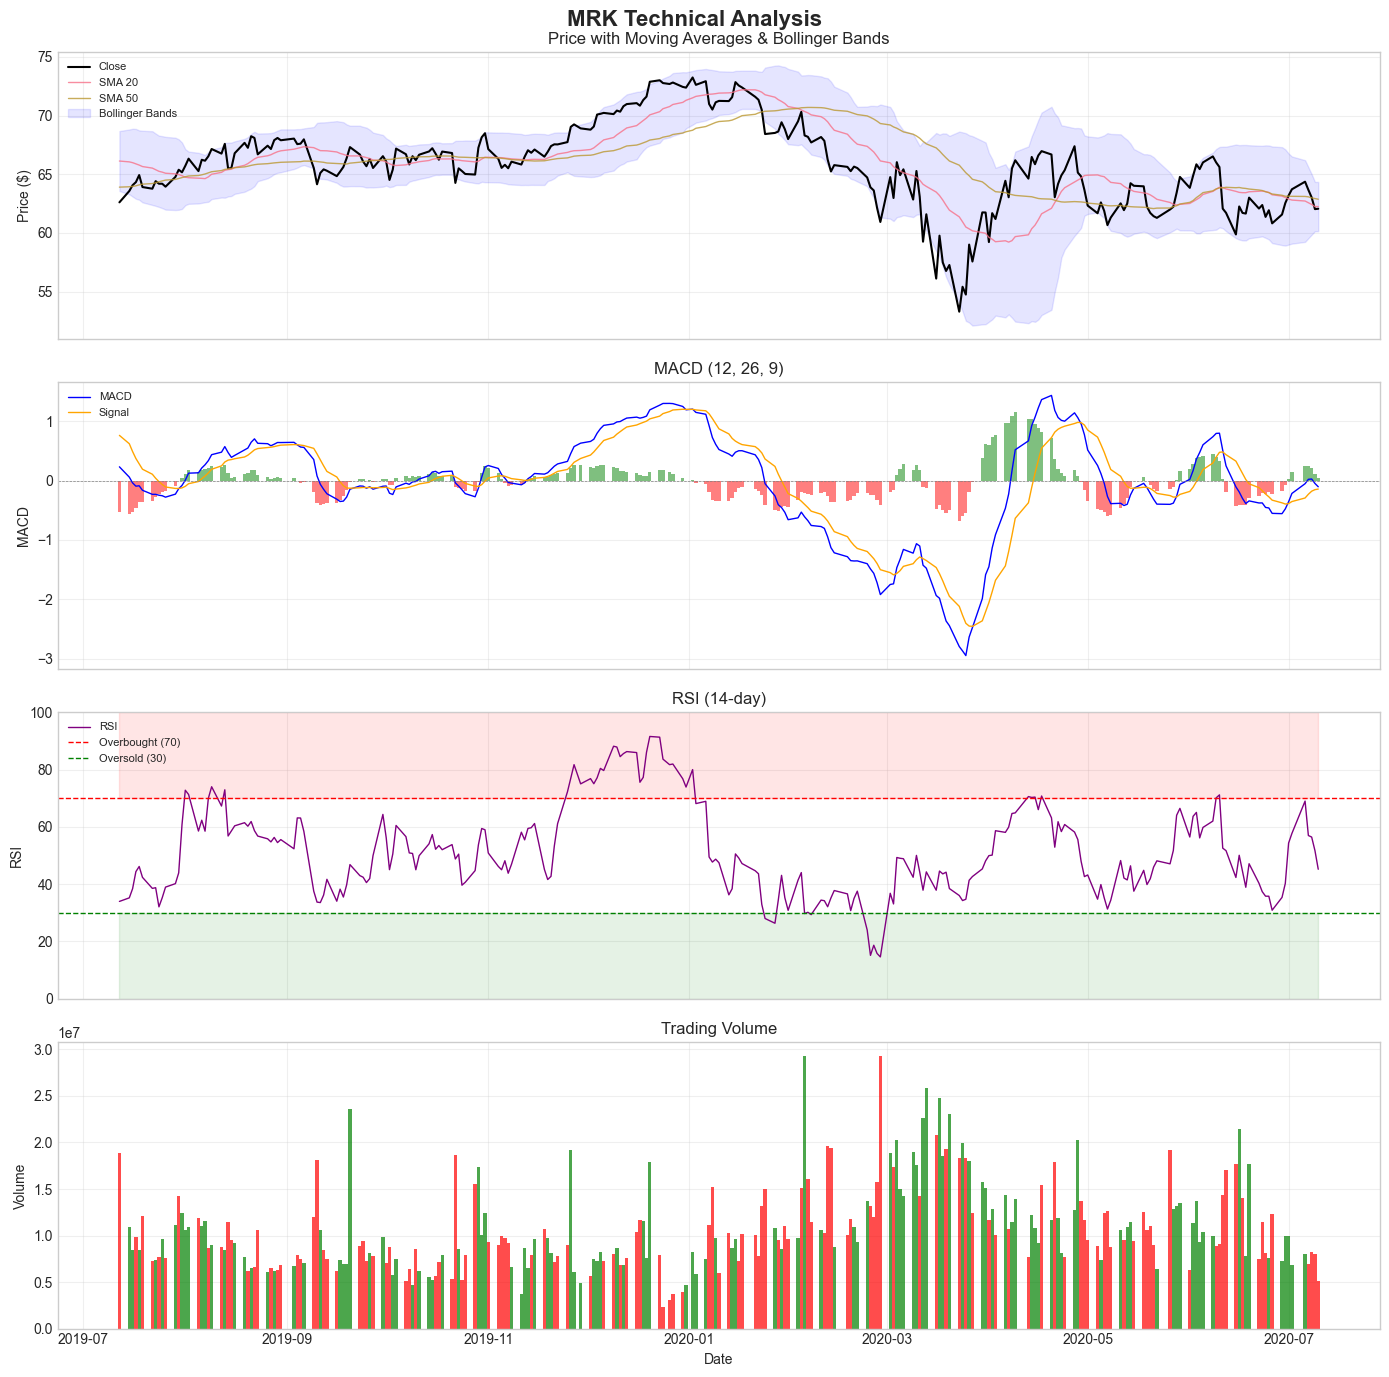

✓ Chart saved: MRK_technical_analysis.png


In [6]:
def plot_technical_analysis(symbol, data, days=252):
    """Create comprehensive technical analysis chart"""
    
    df = data.tail(days)  # Last N days
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
    fig.suptitle(f'{symbol} Technical Analysis', fontsize=16, fontweight='bold')
    
    # --- Plot 1: Price with Moving Averages & Bollinger Bands ---
    ax1 = axes[0]
    ax1.plot(df.index, df['Close'], label='Close', linewidth=1.5, color='black')
    ax1.plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1, alpha=0.8)
    ax1.plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1, alpha=0.8)
    ax1.fill_between(df.index, df['BB_Upper'], df['BB_Lower'], alpha=0.1, color='blue', label='Bollinger Bands')
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Price with Moving Averages & Bollinger Bands')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # --- Plot 2: MACD ---
    ax2 = axes[1]
    ax2.plot(df.index, df['MACD'], label='MACD', linewidth=1, color='blue')
    ax2.plot(df.index, df['MACD_Signal'], label='Signal', linewidth=1, color='orange')
    colors = ['green' if v >= 0 else 'red' for v in df['MACD_Hist']]
    ax2.bar(df.index, df['MACD_Hist'], color=colors, alpha=0.5, width=1)
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_ylabel('MACD')
    ax2.set_title('MACD (12, 26, 9)')
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # --- Plot 3: RSI ---
    ax3 = axes[2]
    ax3.plot(df.index, df['RSI'], label='RSI', color='purple', linewidth=1)
    ax3.axhline(y=70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
    ax3.axhline(y=30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
    ax3.fill_between(df.index, 70, 100, alpha=0.1, color='red')
    ax3.fill_between(df.index, 0, 30, alpha=0.1, color='green')
    ax3.set_ylabel('RSI')
    ax3.set_title('RSI (14-day)')
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # --- Plot 4: Volume ---
    ax4 = axes[3]
    colors = ['green' if df['Close'].iloc[i] >= df['Open'].iloc[i] else 'red' 
              for i in range(len(df))]
    ax4.bar(df.index, df['Volume'], color=colors, alpha=0.7, width=1)
    ax4.set_ylabel('Volume')
    ax4.set_title('Trading Volume')
    ax4.set_xlabel('Date')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../notebooks/{symbol}_technical_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Plot for first stock
first_symbol = list(stock_data.keys())[0]
plot_technical_analysis(first_symbol, stock_data[first_symbol])
print(f"✓ Chart saved: {first_symbol}_technical_analysis.png")

#### Financial Metrics Summary Table

In [7]:
# Calculate summary metrics for all stocks
def calculate_metrics(symbol, df):
    """Calculate key financial metrics"""
    returns = df['Daily_Return'].dropna()
    
    # Annualized metrics (252 trading days)
    ann_return = returns.mean() * 252
    ann_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = ann_return / ann_volatility if ann_volatility != 0 else 0
    
    return {
        'Symbol': symbol,
        'Current Price': df['Close'].iloc[-1],
        'Avg Daily Return (%)': returns.mean(),
        'Daily Volatility (%)': returns.std(),
        'Ann. Return (%)': ann_return,
        'Ann. Volatility (%)': ann_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': returns.min(),
        'Best Day (%)': returns.max(),
        'Current RSI': df['RSI'].iloc[-1],
        'Price vs SMA20 (%)': ((df['Close'].iloc[-1] / df['SMA_20'].iloc[-1]) - 1) * 100
    }

# Generate metrics for all stocks
metrics_list = [calculate_metrics(sym, data) for sym, data in stock_data.items()]
metrics_df = pd.DataFrame(metrics_list)

print("=" * 70)
print("FINANCIAL METRICS SUMMARY")
print("=" * 70)
print(metrics_df.round(2).to_string(index=False))

# Save to CSV
metrics_df.to_csv('../notebooks/stock_metrics_summary.csv', index=False)
print("\n✓ Metrics saved to stock_metrics_summary.csv")

FINANCIAL METRICS SUMMARY
Symbol  Current Price  Avg Daily Return (%)  Daily Volatility (%)  Ann. Return (%)  Ann. Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Best Day (%)  Current RSI  Price vs SMA20 (%)
   MRK          62.06                  0.06                  1.31            14.77                20.80          0.71             -8.90         10.41        45.19               -0.30
    MS          41.85                  0.06                  2.30            13.92                36.50          0.38            -15.60         19.77        59.52                4.18
  NVDA          10.44                  0.16                  2.61            40.61                41.42          0.98            -18.76         29.81        74.07               10.02
    MU          49.49                  0.11                  3.07            28.05                48.66          0.58            -19.82         23.44        49.55                1.52
   QQQ         256.03                  0.08                

#### Compare all stocks

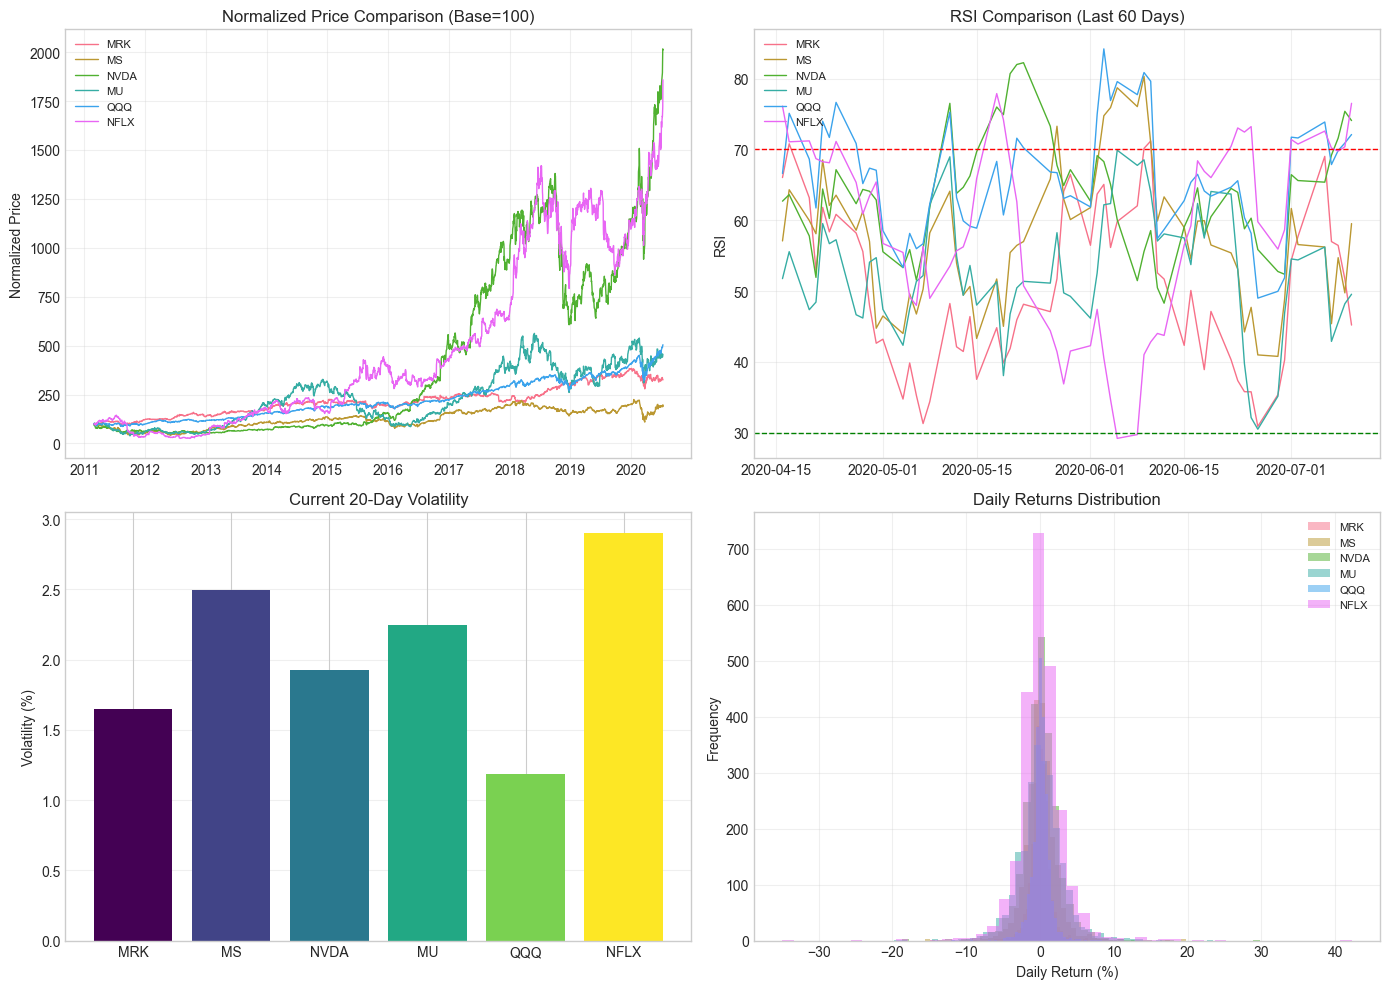

✓ Comparison chart saved


In [8]:
# Visual comparison of all stocks
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Normalized Price Comparison
ax1 = axes[0, 0]
for symbol, df in stock_data.items():
    normalized = df['Close'] / df['Close'].iloc[0] * 100
    ax1.plot(df.index, normalized, label=symbol, linewidth=1)
ax1.set_title('Normalized Price Comparison (Base=100)')
ax1.set_ylabel('Normalized Price')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: RSI Comparison
ax2 = axes[0, 1]
for symbol, df in stock_data.items():
    ax2.plot(df.index[-60:], df['RSI'].iloc[-60:], label=symbol, linewidth=1)
ax2.axhline(y=70, color='red', linestyle='--', linewidth=1)
ax2.axhline(y=30, color='green', linestyle='--', linewidth=1)
ax2.set_title('RSI Comparison (Last 60 Days)')
ax2.set_ylabel('RSI')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Volatility Comparison
ax3 = axes[1, 0]
volatilities = [stock_data[s]['Volatility'].iloc[-1] for s in stock_data]
colors = plt.cm.viridis(np.linspace(0, 1, len(stock_data)))
bars = ax3.bar(stock_data.keys(), volatilities, color=colors)
ax3.set_title('Current 20-Day Volatility')
ax3.set_ylabel('Volatility (%)')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Returns Distribution
ax4 = axes[1, 1]
for symbol, df in stock_data.items():
    ax4.hist(df['Daily_Return'].dropna(), bins=50, alpha=0.5, label=symbol)
ax4.set_title('Daily Returns Distribution')
ax4.set_xlabel('Daily Return (%)')
ax4.set_ylabel('Frequency')
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/stock_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Comparison chart saved")

#### Task 2 Summary 

In [9]:
print("=" * 70)
print("TASK 2 SUMMARY: QUANTITATIVE ANALYSIS")
print("=" * 70)

print(f"""
Stocks Analyzed: {list(stock_data.keys())}
Date Range: {start_date} to {end_date}

Technical Indicators Calculated:
  • Simple Moving Averages (SMA 20, 50)
  • Exponential Moving Averages (EMA 12, 26)
  • MACD (12, 26, 9) with Signal Line & Histogram
  • RSI (14-day)
  • Bollinger Bands (20-day, 2 std)
  • Daily Returns & Volatility

Key Findings:
""")

for _, row in metrics_df.iterrows():
    rsi_status = "Overbought" if row['Current RSI'] > 70 else "Oversold" if row['Current RSI'] < 30 else "Neutral"
    trend = "Above" if row['Price vs SMA20 (%)'] > 0 else "Below"
    print(f"  {row['Symbol']}: RSI={row['Current RSI']:.1f} ({rsi_status}), {trend} SMA20 by {abs(row['Price vs SMA20 (%)']):.1f}%")

TASK 2 SUMMARY: QUANTITATIVE ANALYSIS

Stocks Analyzed: ['MRK', 'MS', 'NVDA', 'MU', 'QQQ', 'NFLX']
Date Range: 2011-02-26 to 2020-07-11

Technical Indicators Calculated:
  • Simple Moving Averages (SMA 20, 50)
  • Exponential Moving Averages (EMA 12, 26)
  • MACD (12, 26, 9) with Signal Line & Histogram
  • RSI (14-day)
  • Bollinger Bands (20-day, 2 std)
  • Daily Returns & Volatility

Key Findings:

  MRK: RSI=45.2 (Neutral), Below SMA20 by 0.3%
  MS: RSI=59.5 (Neutral), Above SMA20 by 4.2%
  NVDA: RSI=74.1 (Overbought), Above SMA20 by 10.0%
  MU: RSI=49.5 (Neutral), Above SMA20 by 1.5%
  QQQ: RSI=72.1 (Overbought), Above SMA20 by 6.3%
  NFLX: RSI=76.5 (Overbought), Above SMA20 by 17.5%
